TO READ: https://drive.google.com/file/d/1cr8vYmjvbVp4iS6KwhNQBn9Nkb3ylVjK/view

In [1]:
import datetime
import os
import re
import urllib
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import describe

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

from wordcloud import WordCloud
import networkx as nx
from gensim.models import KeyedVectors

c:\users\thomas\hpi\textmi~1\venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Data files

# article_id, article_url
SRC_ARTICLES = '../data/guardian-all/articles-standardized.csv'
SRC_AUTHORS = '../data/guardian-all/authors-standardized.csv'
SRC_COMMENTS = '../data/guardian-all/sorted_comments-standardized.csv'
SRC_COMMENTS_POL = '../data/guardian-all/sorted_comments-standardized-pol.csv'
SRC_COMMENTS_POL_ALL = '../data/guardian-all/sorted_comments-standardized-pol-all.csv'
SRC_COMMENTS_POL_TEXT = '../data/guardian-all/sorted_comments-standardized-pol-text.csv'
SRC_COMMENTS_TOKENIZED_BIN = '../data/guardian-all/genzim-guardian-comments-50-tokenized.bin'

OUTPUT_DIR = './week-5-plots'

def plot_timestamps(article_id):
    datetimes = data[data['article_id'] == article_id]['timestamp']
    timestamps = [int(datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").timestamp()) for x in datetimes]
    plt.hist(timestamps)

In [28]:
import re

pattern = re.compile(r'\.com\/([^\/]*)\/([^\/]*)\/')
pattern2 = re.compile(r'\.com\/([^\/]*)')

def get_category(link):
    m = pattern.search(link)
    if not m:
        m = pattern2.search(link)
        return m.group(1)
    return m.group(1)

links = data_articles['article_url'].values
categories = [get_category(x) for x in links]
uniques = np.unique(categories)

In [29]:
np.set_printoptions(threshold=np.inf)
print(uniques)

['artanddesign' 'australia-news' 'big-energy-debate' 'big-ideas' 'books'
 'business' 'business-to-business' 'cardiff'
 'career-changers-into-education' 'careers' 'childrens-books-site'
 'cities' 'commentisfree' 'community' 'crosswords' 'culture'
 'culture-network' 'culture-professionals-network' 'edinburgh' 'education'
 'environment' 'fashion' 'festival-ready' 'film' 'football'
 'forward-women' 'global' 'global-development'
 'global-development-professionals-network' 'gnm-archive'
 'government-computing-network' 'guardian-professional'
 'healthcare-network' 'help' 'higher-education-network' 'housing-network'
 'inequality' 'info' 'international' 'katine' 'law' 'leeds' 'lifeandstyle'
 'local' 'local-government-network' 'media' 'media-network' 'membership'
 'mobile' 'money' 'music' 'naht-edge' 'nanotechnology-world' 'news'
 'politics' 'public-leaders-network' 'science' 'search'
 'small-business-network' 'small-business-network-partner-zone-lloyds-tsb'
 'social-care-careers' 'social-care-n

In [3]:
data_articles = pd.read_csv(SRC_ARTICLES)  # shape = (626395, 2)
data_articles_pol = data_articles[data_articles['article_url'].str.contains('/politics/')]  # shape = (20167, 2)
data_authors = pd.read_csv(SRC_AUTHORS)
data_comments_pol = pd.read_csv(SRC_COMMENTS_POL_ALL)

article_ids = data_comments_pol['article_id'].unique()  # 2876 ids

In [117]:
upvotes_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').sum().iloc[:, 0]
comments_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').count().iloc[:, 0]
mean_upvotes_per_author = upvotes_per_author / comments_per_author

In [97]:
replies_count = pd.Series(index=data_comments_pol['comment_id'], data=0)
parent_comment_ids = data_comments_pol['parent_comment_id']
for parent_id in parent_comment_ids[~parent_comment_ids.isnull()].values:
    if parent_id in replies_count:
        replies_count.loc[parent_id] += 1

In [98]:
print('row:', data_comments_pol['upvotes'].values.argmax())
print('upvotes:', data_comments_pol['upvotes'].max())
print('author_id:', data_comments_pol.iloc[3197]['author_id'])

row: 661077
upvotes: 704
author_id: 30579


In [167]:
extracted_features = dict()
extracted_features['upvotes'] = data_comments_pol['upvotes'].values
extracted_features['replies'] = replies_count.loc[data_comments_pol['comment_id']].values
extracted_features['text_length'] = data_comments_pol['comment_text'].str.len().values
extracted_features['author_upvotes'] = upvotes_per_author.loc[data_comments_pol['author_id']].values
extracted_features['author_comments'] = comments_per_author.loc[data_comments_pol['author_id']].values
extracted_features['mean_author_upvotes'] = mean_upvotes_per_author.loc[data_comments_pol['author_id']].values

# TODO:
# Rang
# Rechtschreibung (cluster words?)
# Amount of words
# Mean amount of words in a sentence
# Ähnlichkeit von Comment and Article (used words from articles wordcloud)
# Grammatik (use pretrained model)

In [168]:
extracted_features_df = pd.DataFrame.from_dict(extracted_features)

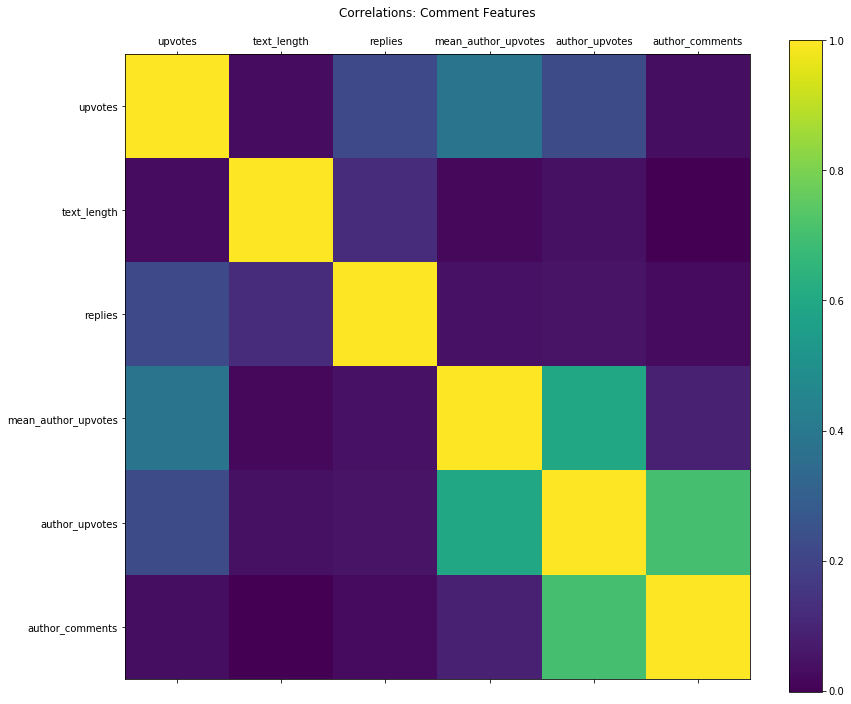

In [199]:
labels = list(reversed(extracted_features_df.columns))

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
cax = ax.matshow(extracted_features_df[extracted_features_df['author_comments'] > 1000][labels].corr())
cbar = fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_title('Correlations: Comment Features')
fig.savefig('comments_from_1000er_authors.pdf')
fig.savefig('comments_from_1000er_authors.png')

In [ ]:
# class for top 10 comments (not equal distributed classes)
# classweights for loss functions (weights per class)
# otherwise over oder under sampling

### Data augmentation translate german to english and vice versa